### EDA

#### Load the data and quick glance

In [4]:
import pandas as pd
import numpy as np
import plotly.express as px

data_path = "challenge_dataset.csv"
df = pd.read_csv(data_path)
df.head()

,CustomerID,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,Churn
0,55388,5.0,Mobile Phone,1,9.0,Debit Card,4.0,4,Mobile Phone,3.0,3,0.0,15.0,2.0,2.0,4.0,159.77,0.0
1,52565,2.0,Phone,1,15.0,CC,NaN,3,Mobile,3.0,10,0.0,17.0,0.0,1.0,2.0,129.74,0.0
2,50690,13.0,Mobile Phone,1,20.0,Credit Card,2.0,4,Others,3.0,2,0.0,NaN,4.0,4.0,9.0,296.26,0.0
3,52456,NaN,Phone,1,8.0,Debit Card,3.0,3,Mobile,5.0,2,1.0,12.0,1.0,1.0,0.0,120.74,1.0
4,51153,19.0,Mobile Phone,1,8.0,Credit Card,2.0,3,Others,1.0,8,1.0,NaN,1.0,2.0,2.0,293.28,0.0


In [2]:
df.set_index('CustomerID', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4661 entries, 55388 to 53411
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Tenure                       4430 non-null   float64
 1   PreferredLoginDevice         4661 non-null   object 
 2   CityTier                     4661 non-null   int64  
 3   WarehouseToHome              4444 non-null   float64
 4   PreferredPaymentMode         4661 non-null   object 
 5   HourSpendOnApp               4453 non-null   float64
 6   NumberOfDeviceRegistered     4661 non-null   int64  
 7   PreferedOrderCat             4577 non-null   object 
 8   SatisfactionScore            4283 non-null   float64
 9   NumberOfAddress              4661 non-null   int64  
 10  Complain                     4559 non-null   float64
 11  OrderAmountHikeFromlastYear  4429 non-null   float64
 12  CouponUsed                   4458 non-null   float64
 13  OrderCount        

In [5]:
cat_cols = ['PreferredLoginDevice', 'CityTier', 'PreferredPaymentMode', 'PreferedOrderCat', 'Complain']
numeric_cols = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']
label_col = 'Churn'


<Axes: >

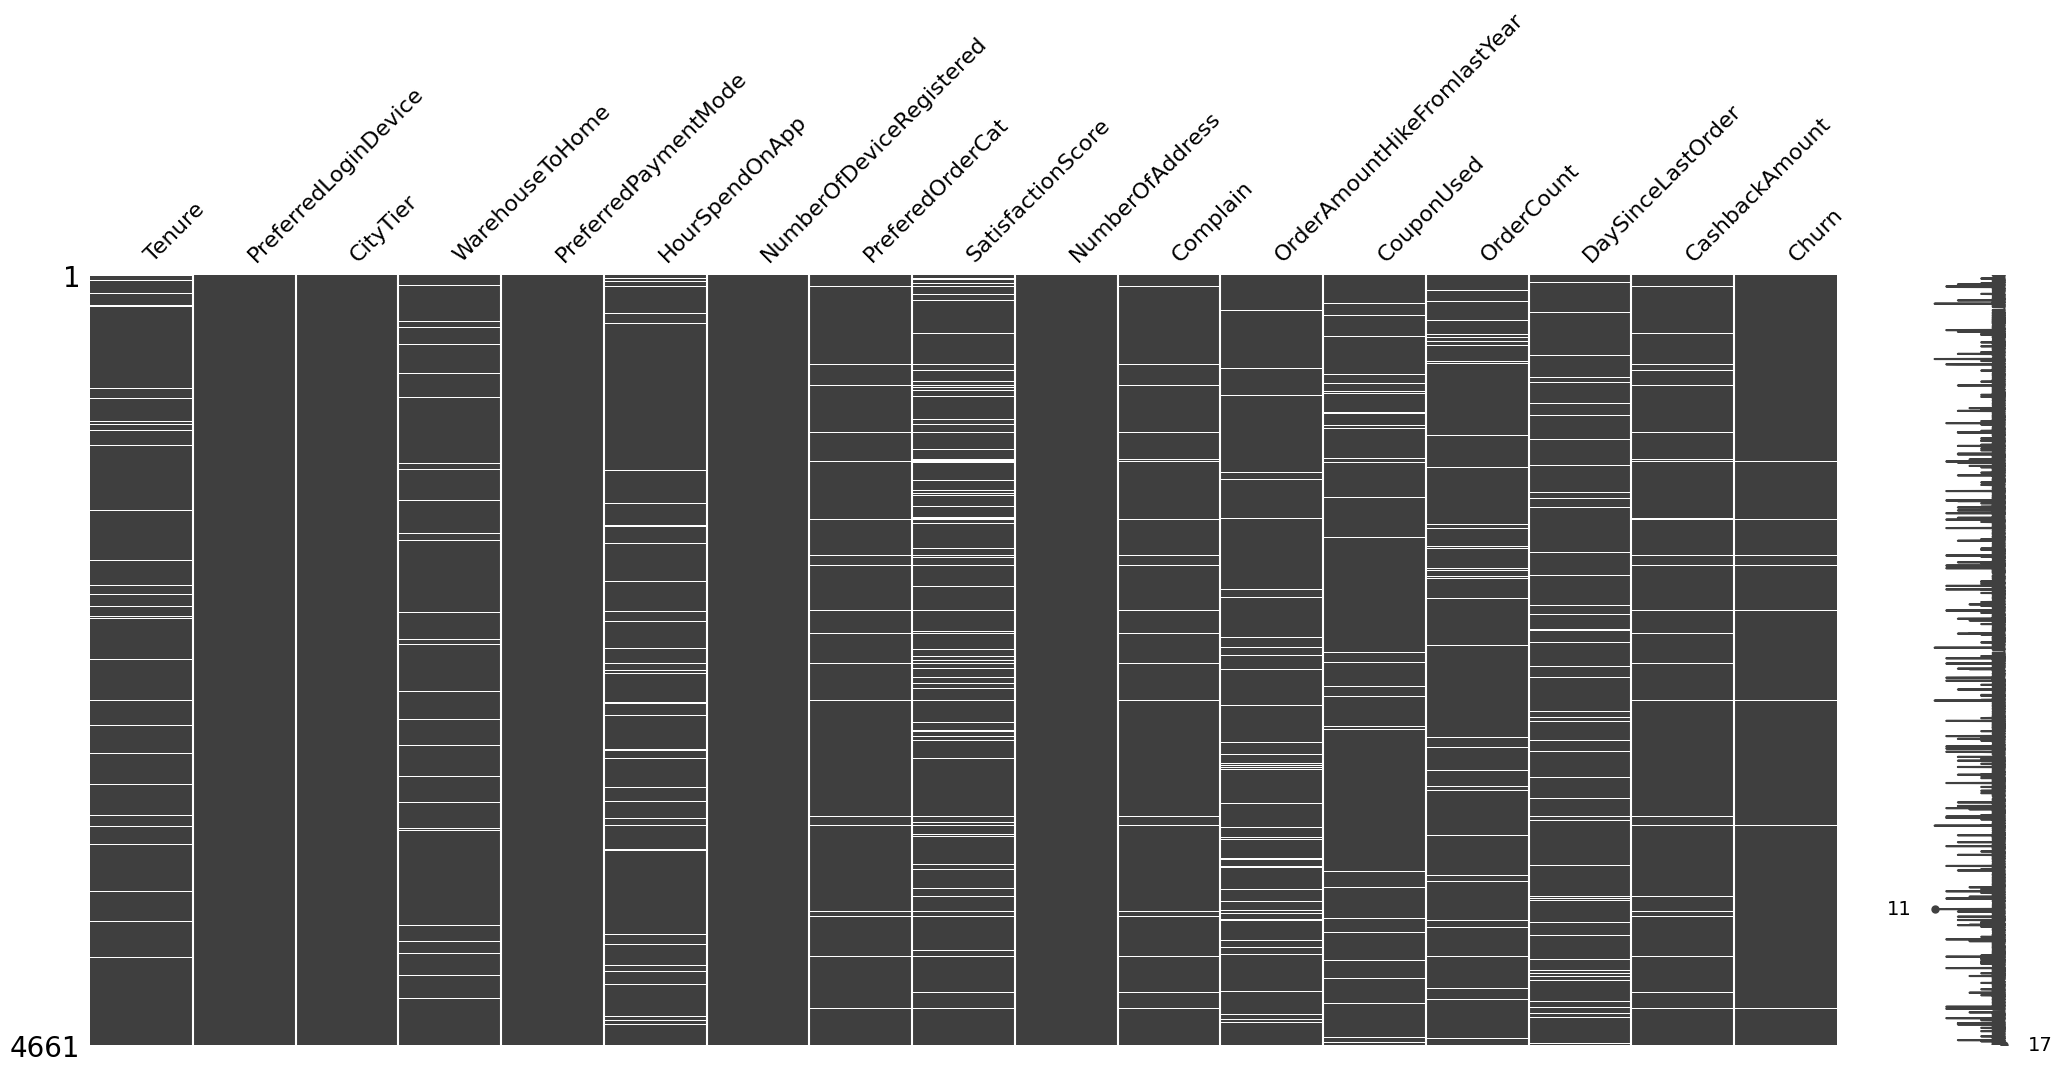

In [4]:
# There are missing values in the data
# Check them out.
import missingno as msno
%matplotlib inline
msno.matrix(df)


<Axes: >

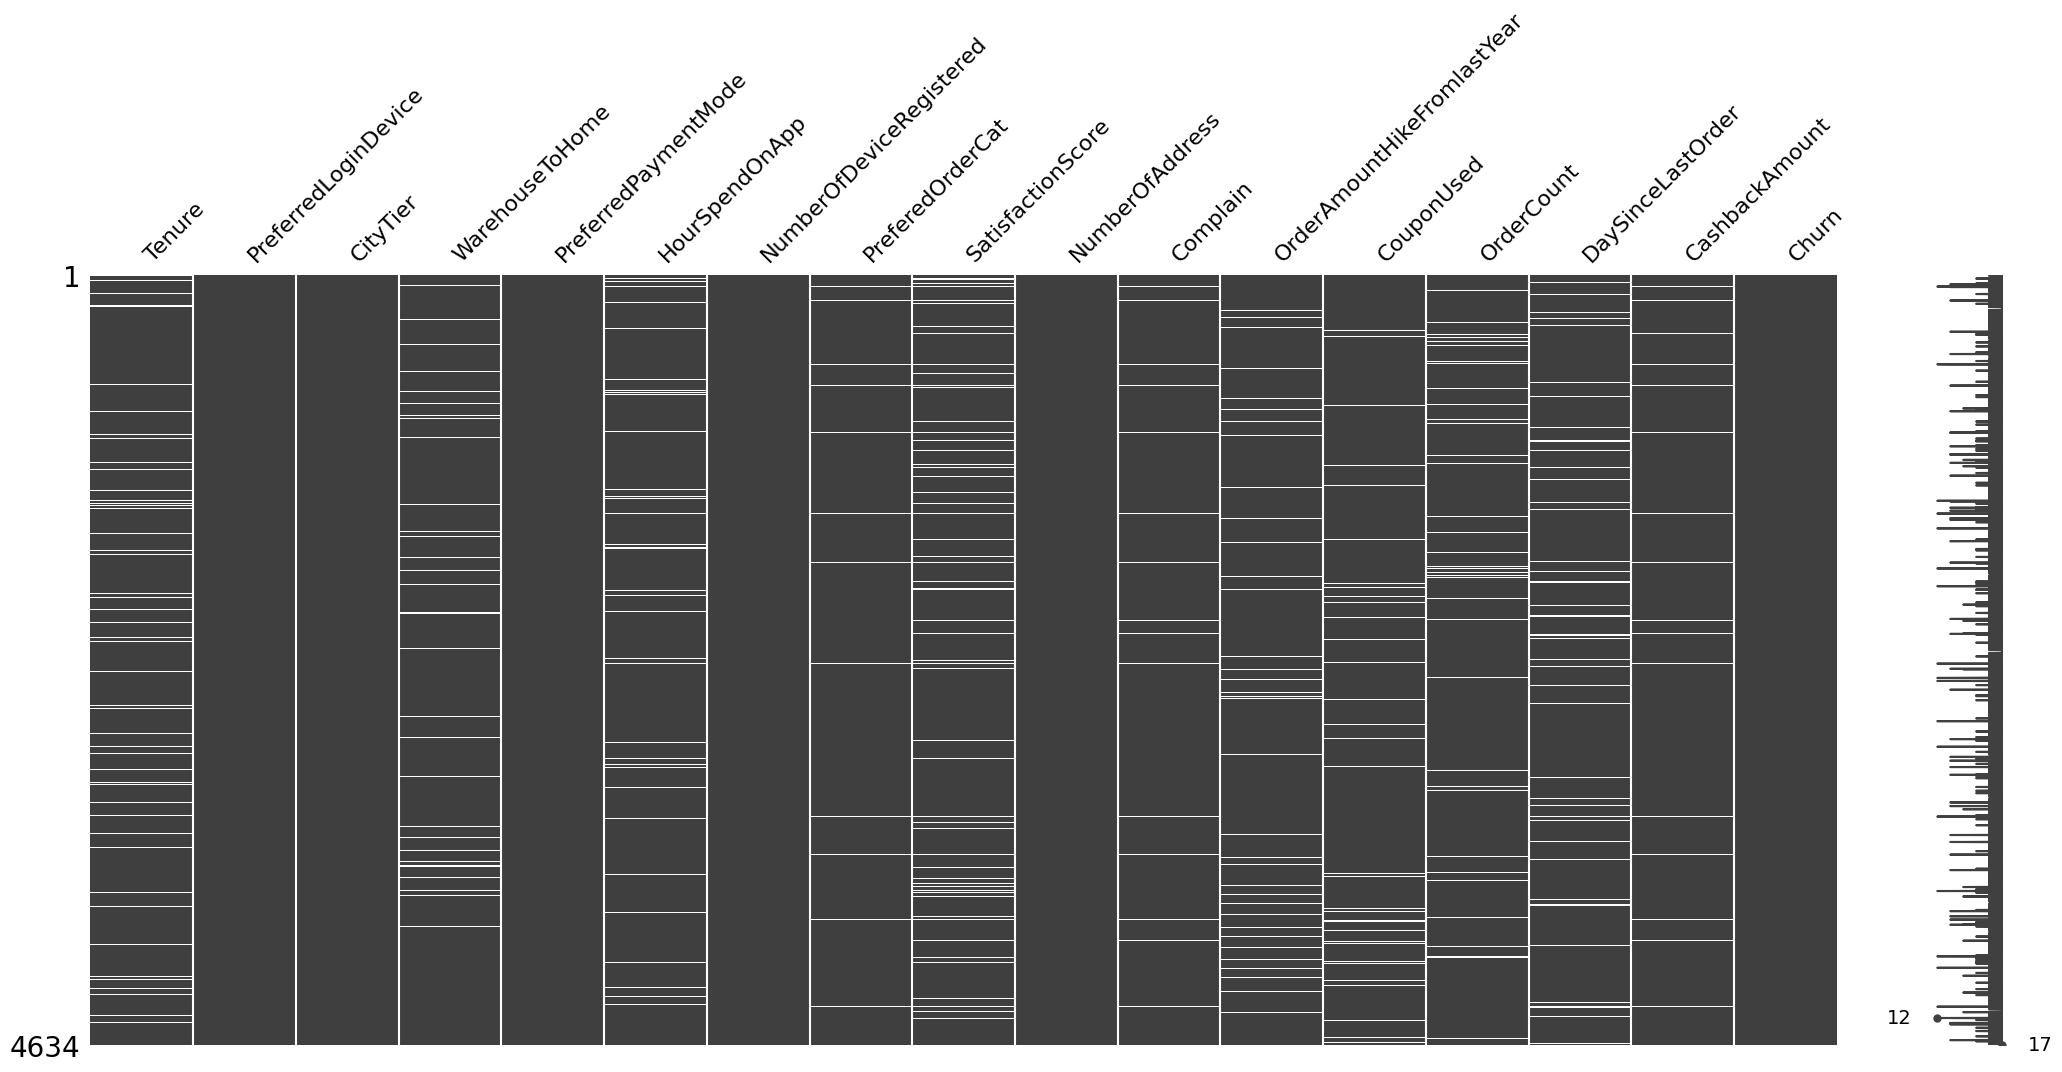

In [5]:
# remove data that has missing values in churn
df_ms_churn = df[df['Churn'].isnull()]
df = df.dropna(subset=['Churn'])
msno.matrix(df)

#### Charts and metrics

In [6]:
# bar charts looking at values of numeric columns vs churn
chart_df = df.copy()
churn_map = {1: 'Churned', 0: 'Not Churned'}
chart_df['Churn'] = chart_df['Churn'].map(churn_map)

for col in numeric_cols:
    fig = px.box(chart_df, y=col, x='Churn')
    fig.update_layout(title=f'Churn by {col}', yaxis_title=f'Average value of {col}', xaxis_title='Churn')
    fig.show()


Looking at the features above, I have the following observations
* Tenure: Churned customer has much shorter tenure, when behaviours haven't formed
* Distance from warehouse to home, there doesn't seem to be a huge difference between churned and not churned in terms of distance from warehouse
* Hour spend on app: similar to above.
* Number of device resgitstered: above 4 devices, there is a higher risk of churn
* Satisfaction score: churned customers actually have higher satisfaction scores?
* Number of address: similar risk of churn
* Order amount hike from lack year: similar risk of churn
* Coupon used: similar risk of churn
* Order count: similar risk of churn
* Day since last order: less days since last order for churned group
* Cashback amount: less cashback for churned group

In [6]:
# therefore we update selected numeric columns
numeric_cols_select = ['Tenure', 'NumberOfDeviceRegistered', 'SatisfactionScore', 'DaySinceLastOrder', 'CashbackAmount']

In [ ]:
# encode
chart_df = df.copy()
chart_df.fillna('Missing', inplace=True)
chart_df['CityTier'] = chart_df['CityTier'].astype('category')
chart_df['Complain'] = chart_df['Complain'].astype('category')

/var/folders/1s/nwltm22d6ns36jdd9j4s2f_r0000gp/T/ipykernel_33513/610939124.py:3: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Missing' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



In [16]:
# look at churn rate by categorical columns
for col in cat_cols:
    fig = px.histogram(chart_df, x=col, y='Churn', histfunc='avg')
    fig.update_layout(title=f'Churn by {col}', yaxis_title='Average value of Churn', xaxis_title=col)
    fig.show()

All of the categorical variable seems to make sense. Keep all

#### Data prep

In [13]:
# reload data
data_path = "challenge_dataset.csv"
df = pd.read_csv(data_path)
df.set_index('CustomerID', inplace=True)
df = df.dropna(subset=['Churn'])

<Axes: >

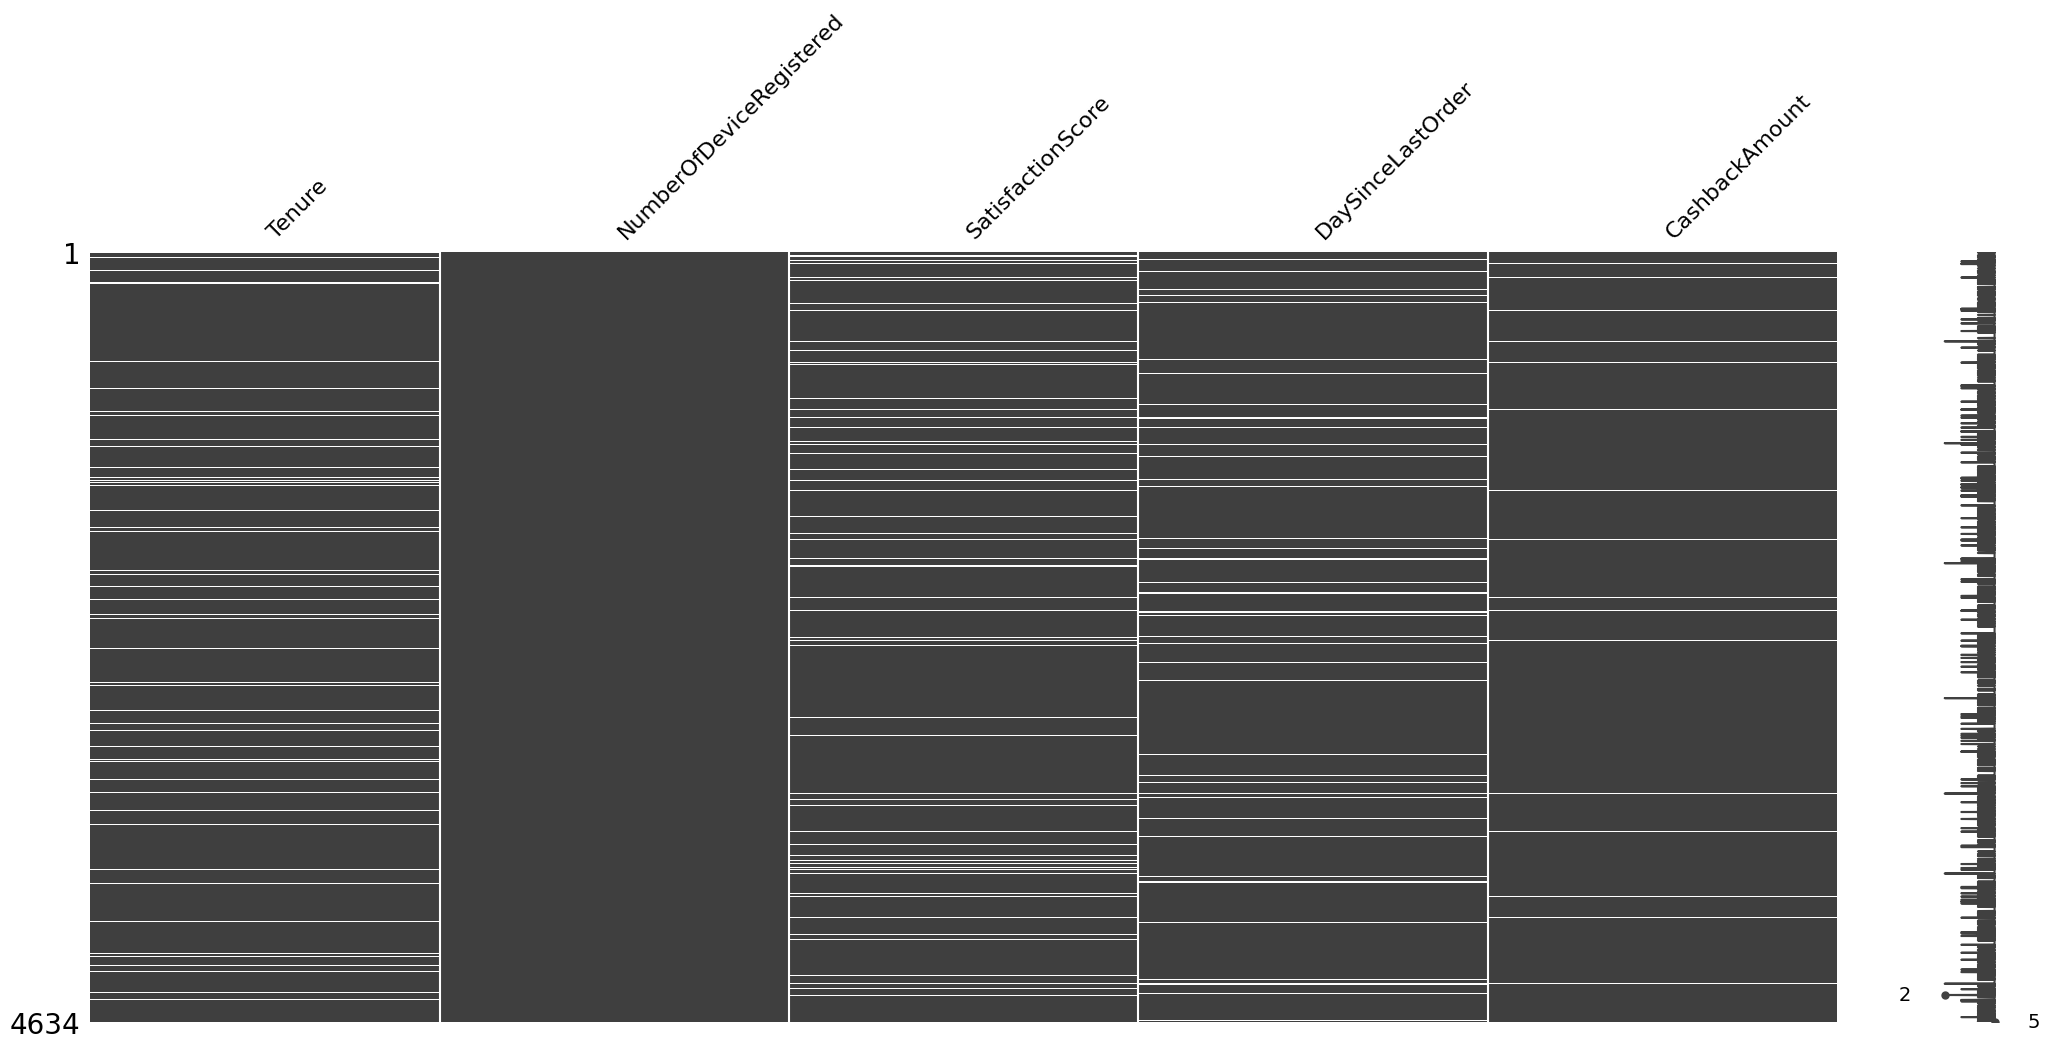

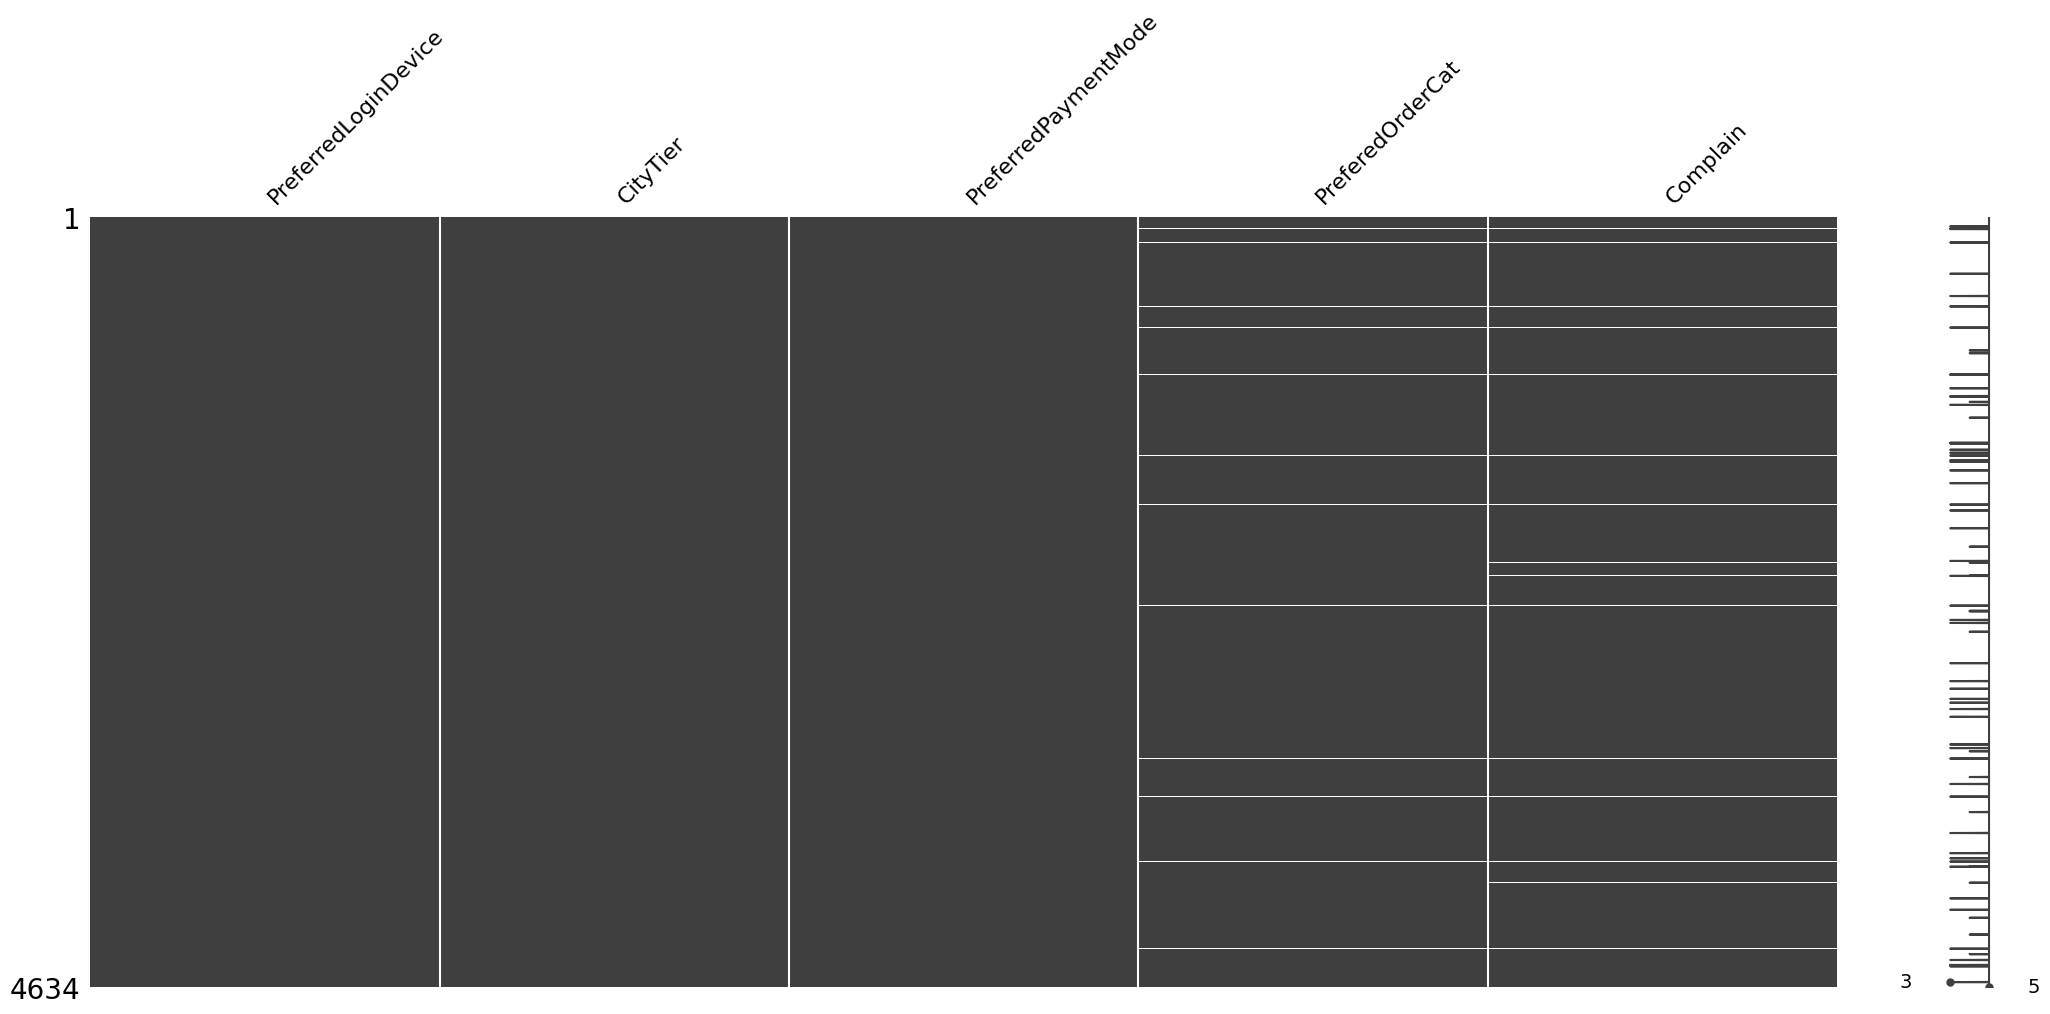

In [14]:
import missingno as msno
msno.matrix(df[numeric_cols_select])
msno.matrix(df[cat_cols])

In [15]:
# impute missing values for numeric columns
from sklearn.impute import KNNImputer
missing_cols = []
for col in numeric_cols_select:
    if df[col].isnull().sum() > 0:
        df[f'{col}_missing'] = df[col].isnull()
        missing_cols.append(f'{col}_missing')
imputer = KNNImputer(n_neighbors=5)
df[numeric_cols_select]= imputer.fit_transform(df[numeric_cols_select])

In [16]:
# create dummies for categorical columns
df[cat_cols]=df[cat_cols].fillna('Missing')
df[cat_cols] = df[cat_cols].astype(str)
# df[cat_cols] = df[cat_cols].astype('category')

In [27]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
after_enc = encoder.fit_transform(df[cat_cols])
cat_onehot_cols = encoder.get_feature_names_out(input_features=cat_cols)
df[cat_onehot_cols] = after_enc.toarray()

#### Modelling

In [36]:
all_features = numeric_cols_select + list(cat_onehot_cols) + missing_cols

X = df[all_features]
y = df['Churn']
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=2, random_state=42, shuffle=True)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
params = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [2, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2, 5],
}

rf = RandomForestClassifier()
random_search = RandomizedSearchCV(estimator = rf, param_distributions = params, n_iter = 100, cv = 5,random_state=42, n_jobs = -1)
random_search.fit(X_train, y_train)


/Users/luluo/luluo/Job/redcloud/technical_challenge/venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 72 is smaller than n_iter=100. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [2, 5, 10],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [2, 5],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42)

In [39]:
best_model = random_search.best_estimator_

In [40]:
from sklearn.metrics import classification_report, f1_score
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f1_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.90      0.98      0.94      1930
         1.0       0.83      0.45      0.58       387

    accuracy                           0.89      2317
   macro avg       0.86      0.72      0.76      2317
weighted avg       0.89      0.89      0.88      2317

0.5843071786310517
